### Importing all the libraries required 

In [235]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from itertools import cycle
import json
import pandas as pd
import numpy as np
import sagemaker
import boto3
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference
import random
import numpy as np                                # For performing matrix operations and numerical processing
import pandas as pd                               # For manipulating tabular data
from time import gmtime, strftime                 
import os 

In [236]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch

### Defining a function that draws a bounding box around the images

In [237]:
class_name='plastic-bottle'
def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)
    

    colors = cycle(['g', 'r', 'b', 'y', 'c', 'm', 'k', 'w'])
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=1.5,edgecolor=next(colors),facecolor='none')
           
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        #Adding text to the bounding box
        ax.text(bbox['left'],bbox['top'],"Plastic-bottle(0.75)", fontsize=9)
        
    plt.show()

### Code option for intiating training job

In [ ]:
import time

import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

training_image = sagemaker.amazon.amazon_estimator.get_image_uri(
    boto3.Session().region_name, 'object-detection', repo_version='latest')
s3_output_path = 's3://{}/{}/output'.format(BUCKET, pfx_training)


training_job_name = 'training-job-plasticbottle'

training_params = \
    {
        "AlgorithmSpecification": {
            
            "TrainingImage": training_image,
            "TrainingInputMode": "Pipe"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": s3_output_path
        },
        "ResourceConfig": {
            "InstanceCount": 1,
            "InstanceType": "ml.p2.xlarge",
            "VolumeSizeInGB": 50
        },
        "TrainingJobName": training_job_name,
        "HyperParameters": {  
            "base_network": "resnet-50",
            "use_pretrained_model": "1",
            "num_classes": "1",
            "mini_batch_size": "2",
            "epochs": "100",
            "learning_rate": "0.0001",
            "lr_scheduler_step": "",
            "lr_scheduler_factor": "0.1",
            "optimizer": "sgd",
            "momentum": "0.9",
            "weight_decay": "0.0005",
            "overlap_threshold": "0.5",
            "nms_threshold": "0.45",
            "image_shape": "300",
            "label_width": "350",
            "num_training_samples": str(num_training_samples)
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 86400
        },
        "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                        "S3Uri": s3_train_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        "AttributeNames": ['source-ref', 'Plastic-Bottle']
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            },
            {
                "ChannelName": "validation",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile", # We are using augmented manifest file for training
                        "S3Uri": s3_validation_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        "AttributeNames": ['source-ref', 'Plastic-Bottle']
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            }
        ]
    }
# Creating Sagemaker training job
client = boto3.client(service_name='sagemaker')
client.create_training_job(**training_params)

# Checking the status of training job
status = client.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

<a name='review_training'></a>

## Reviewing Training results


End point creation
Step1: Creating SM model from model artifacts 

In [246]:
client = boto3.client('sagemaker')

In [247]:
training_job_name = 'training-job-plasticbottle'
training_info = client.describe_training_job(TrainingJobName=training_job_name)

print("Training job info: ", training_info)
print("Training job status: ", training_info['TrainingJobStatus'])
print("Secondary status: ", training_info['SecondaryStatus'])

Training job info:  {'TrainingJobName': 'training-job-plasticbottle', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:364697339974:training-job/training-job-plasticbottle', 'ModelArtifacts': {'S3ModelArtifacts': 's3://lidv1/ouput/training-job-plasticbottle/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'base_network': 'resnet-50', 'early_stopping': 'false', 'early_stopping_min_epochs': '10', 'early_stopping_patience': '5', 'early_stopping_tolerance': '0.0', 'epochs': '30', 'freeze_layer_pattern': 'false', 'image_shape': '300', 'label_width': '350', 'learning_rate': '0.001', 'lr_scheduler_factor': '0.1', 'mini_batch_size': '2', 'momentum': '0.9', 'nms_threshold': '0.45', 'num_classes': '1', 'num_training_samples': '235', 'optimizer': 'sgd', 'overlap_threshold': '0.5', 'use_pretrained_model': '1', 'weight_decay': '0.0005'}, 'AlgorithmSpecification': {'TrainingImage': '825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detectio

In [240]:
import time
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name = training_job_name + '-model' + timestamp

training_image = training_info['AlgorithmSpecification']['TrainingImage']
model_data = training_info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

In [241]:
from sagemaker import get_execution_role

role = get_execution_role()

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-2:364697339974:model/training-job-plasticbottle-model-2020-09-20-19-07-11


In [242]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = training_job_name + '-epc' + timestamp
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: training-job-plasticbottle-epc-2020-09-20-19-07-32
Endpoint configuration arn:  arn:aws:sagemaker:us-east-2:364697339974:endpoint-config/training-job-plasticbottle-epc-2020-09-20-19-07-32


In [243]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = training_job_name + '-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: training-job-plasticbottle-ep-2020-09-20-19-07-36
EndpointArn = arn:aws:sagemaker:us-east-2:364697339974:endpoint/training-job-plasticbottle-ep-2020-09-20-19-07-36


In [244]:
endpoint_name="training-job-plasticbottle-ep-2020-09-20-19-07-36"
# get the status of the endpoint
response = client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

EndpointStatus = Creating


### Perform inference
We shall invoke the endpoint we have created and test the images in the test folder which we have created with the images which model has never seen.

In [231]:
import glob

test_images = glob.glob('test-plastic-inreceptacle/*')
print(*test_images, sep="\n")

test-plastic-inreceptacle/IMG_9301.JPG
test-plastic-inreceptacle/IMG_8792 (2).JPG
test-plastic-inreceptacle/IMG_6179.JPG
test-plastic-inreceptacle/IMG_8848 (2).JPG
test-plastic-inreceptacle/IMG_9330.JPG
test-plastic-inreceptacle/IMG_9343.JPG
test-plastic-inreceptacle/IMG_6187.JPG
test-plastic-inreceptacle/IMG_9346.JPG
test-plastic-inreceptacle/IMG_9359 (3).JPG
test-plastic-inreceptacle/IMG_6202.JPG
test-plastic-inreceptacle/IMG_8811.JPG
test-plastic-inreceptacle/IMG_6190.JPG
test-plastic-inreceptacle/IMG_9367 (2).JPG
test-plastic-inreceptacle/IMG_9844 (2).JPG


In [232]:
def prediction_to_bbox_data(image_path, prediction, threshold=0.5):
    class_id, confidence, xmin, ymin, xmax, ymax = prediction
    width, height = Image.open(image_path).size
    bbox_data = {'class_id': class_id,
               'height': (ymax-ymin)*height,
               'width': (xmax-xmin)*width,
               'left': xmin*width,
               'top': ymin*height}
    return bbox_data

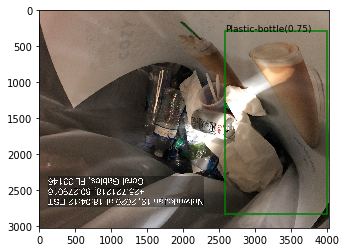

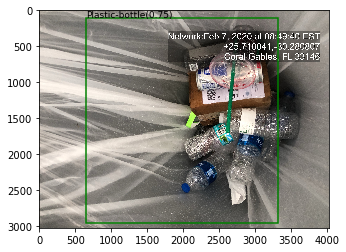

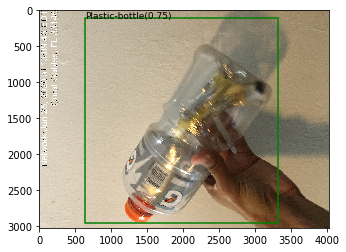

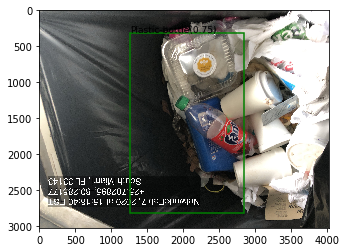

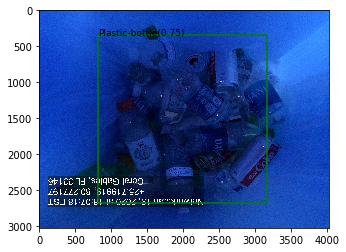

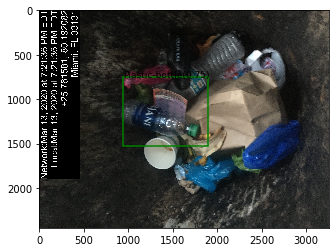

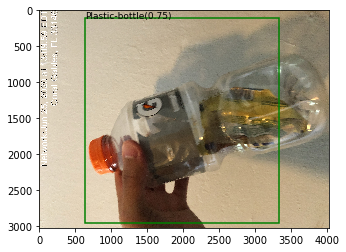

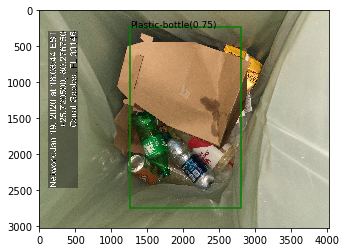

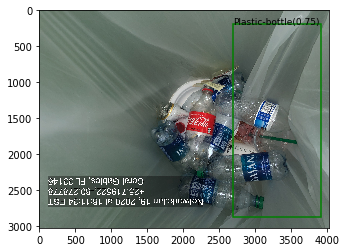

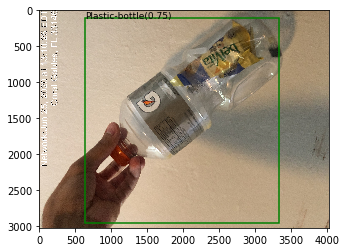

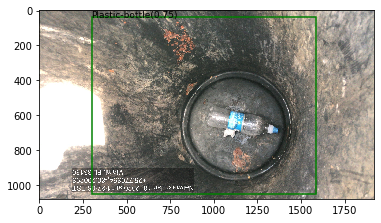

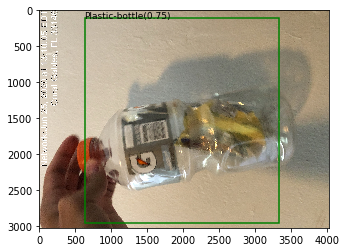

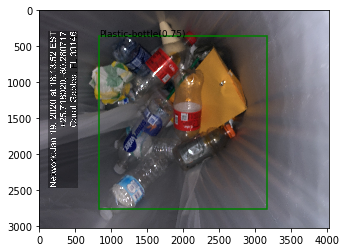

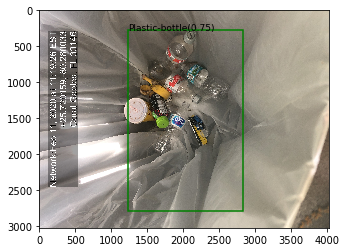

In [233]:
import matplotlib.pyplot as plt

runtime_client = boto3.client('sagemaker-runtime')

# Call SageMaker endpoint to obtain predictions
def get_predictions_for_img(runtime_client, endpoint_name, img_path):
    with open(img_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)

    result = response['Body'].read()
    result = json.loads(result)
    return result


# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
if status != 'InService':
    raise Exception('Endpoint creation failed.')

for test_image in test_images:
    result = get_predictions_for_img(runtime_client, endpoint_name, test_image)
    confidence_threshold = .280
    best_n = 1
    # display the best n predictions with confidence > confidence_threshold
    predictions = [prediction for prediction in result['prediction'] if prediction[1] > confidence_threshold]
    predictions.sort(reverse=True, key = lambda x: x[1])
    bboxes = [prediction_to_bbox_data(test_image, prediction) for prediction in predictions[:best_n]]
    show_annotated_image(test_image, bboxes)

### Cleaning up the endpoint 

In [245]:
client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '0ede6c89-c48e-4033-a86a-4d8534dc35a3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0ede6c89-c48e-4033-a86a-4d8534dc35a3',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sun, 20 Sep 2020 20:29:48 GMT'},
  'RetryAttempts': 0}}